<a href="https://colab.research.google.com/github/9berny9/bikes/blob/main/bikes_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import pandas as pd
import numpy as np
import geopy.distance
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.metrics import DistanceMetric
from scipy import stats
import seaborn as sns

# BIKES IN EDINBURGH
1. [Zadání](#1)
2. [Úprava dat](#2)
3. [Analýza](#3)



## Zadání <a name="1"></a>



V Edinburghu, stejně jako v dalších městech, funguje systém "bike sharing" - ve městě jsou stanice s koly, člověk si může nějaké půjčit a potom ho vrátit v nějaké další stanici. Problém je, že v některých stanicích se kola pravidelně hromadí a jinde naopak chybí. Provozovatel kol, firma Just Eat Cycles, zadala projekt, jehož cílem je systém zefektivnit.

Coby datový analytik jste součástí týmu, který na projektu pracuje. Vaším úkolem je zpracovat relevantní data a zjistit z nich informace užitečné pro zbytek týmu. Máte k dispozici data o všech výpůjčkách (na ENGETO databázi v tabulce edinburgh_bikes). Proveďte standardní deskriptivní statistiku dat. Také zjistěte minimálně následující informace:

*   identifikujte aktivní a neaktivní stanice
*   identifikujte nejfrekventovanější stanice
*   identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí
*   spočítejte vzdálenosti mezi jednotlivými stanicemi
jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty, zobrazte histogram   
Analýza poptávky:

*   zobrazte vývoj poptávky po půjčování kol v čase
*   identifikujte příčiny výkyvů poptávky
*   zjistěte vliv počasí na poptávku po kolech (údaje o počasí v Edinburghu jsou v tabulce edinburgh_weather)
*   půjčují si lidé kola více o víkendu než během pracovního týdne?

Výstupem analýzy bude ideálně jupyter notebook nebo colab notebook uložený na Vašem githubu. Výstupy Vaší analýzy musí být zřejmé i bez spouštění kódu. V textových buňkách popište, jak jste postupovali a napište své závěry. Pokud v zadání chybí nějaká informace, doplňte ji podle vlastního uvážení, své rozhodnutí uveďte a vysvětlete v notebooku.

## Načtení databáze <a name="2"></a>

Pro zjednodušení a prezentaci práce si vytvořím pickle databáze, s kterým budu pracovat. V reálném projektu bych pracoval přímo s databází.  

Postup:
1.   Načtení databáze do jednotlivých dataframů -> `data = pd.read_sql(sql=query, con=engine)`
2.   Uložení dataframů jako pickle na github -> `data.to_pickle("data_basic.pkl")`
3.   Načtení pickle z repozitáře

Z databáze jsme si vytvořili **bikes.pkl** a **weather.pkl**, s kterými budeme pracovat.


Pro načtení souboru z repozitáře si naklonupujeme repozitář do colabu.

In [2]:
!git clone https://github.com/9berny9/bikes

Cloning into 'bikes'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 141 (delta 5), reused 27 (delta 4), pack-reused 110
Receiving objects: 100% (141/141), 42.80 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (12/12), done.


### Bikes

Databáze bikes obsahuje informace o datumu a času vypůjčení kol s iformacemi o místě převzetí kola a jeho vrácení.

In [3]:
# url github clonovaného repositáře v Colabu
url_bikes_basic = "/content/bikes/Database/downloaded_data/bikes_first.pkl"
# načtení do dataframu
dfb = pd.read_pickle(url_bikes_basic)

### Weather <a name="2"></a>

Databáze Weather obsahuje informace o datumu a času měření údajů o počasí v městě Edinburgh. Měření jsou prováděny každé 3 hodiny.

In [4]:
# url github clonovaného repositáře v Colabu
url_weather = "/content/bikes/Database/downloaded_data/weather_first.pkl"
# načtení do dataframu
dfw = pd.read_pickle(url_weather)

## Úprava dat <a name="2"></a>

### Bikes

In [5]:
dfb.head()

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


In [85]:
#zjištění NaN hodnot v datech
dfb.isna().sum()

start                   0
end                     0
duration                0
start_id                0
start_name              0
start_description    2710
start_latitude          0
start_longitude         0
end_id                  0
end_name                0
end_description      3003
end_latitude            0
end_longitude           0
distance                0
dtype: int64

Nulové hodnoty se nachází pouze v popise stanic, což pro nás není důležité.

In [6]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438259 entries, 0 to 438258
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   index                      438259 non-null  int64  
 1   started_at                 438259 non-null  object 
 2   ended_at                   438259 non-null  object 
 3   duration                   438259 non-null  int64  
 4   start_station_id           438259 non-null  int64  
 5   start_station_name         438259 non-null  object 
 6   start_station_description  435549 non-null  object 
 7   start_station_latitude     438259 non-null  float64
 8   start_station_longitude    438259 non-null  float64
 9   end_station_id             438259 non-null  int64  
 10  end_station_name           438259 non-null  object 
 11  end_station_description    435256 non-null  object 
 12  end_station_latitude       438259 non-null  float64
 13  end_station_longitude      43

In [7]:
# datový formát datetime64
dfb['started_at'] = pd.to_datetime(dfb['started_at'], format="%Y-%m-%d %H:%M")
dfb['ended_at'] = pd.to_datetime(dfb['ended_at'], format="%Y-%m-%d %H:%M")

In [8]:
# převedení sloupce duration z float na timedelta
dfb['duration'] = pd.to_timedelta(dfb['duration'], unit="s") 

In [9]:
# přejmenování sloupců na kratší názvy
dfb = dfb.rename(columns={"started_at": "start", "ended_at": "end",
        "start_station_id": "start_id", "start_station_name": "start_name",
        "start_station_description": "start_description",
        "start_station_latitude": "start_latitude",
        "start_station_longitude": "start_longitude","end_station_id": "end_id",
        "end_station_name": "end_name", 
        "end_station_description": "end_description",
        "end_station_latitude": "end_latitude",
        "end_station_longitude": "end_longitude"
        })

In [10]:
# Vzdálenosti mezi stanicemi zapůjčení a vrácení
def distance_calc(row):
    start = (row['start_latitude'], row['start_longitude'])
    end = (row['end_latitude'], row['end_longitude'])

    return geopy.distance.great_circle(start, end).km

dfb['distance'] = dfb.apply(lambda row: distance_calc(row), axis=1)

In [11]:
# odstranění sloupce
dfb = dfb.drop(columns= "index")

In [12]:
dfb.head()

,start,end,duration,start_id,start_name,start_description,start_latitude,start_longitude,end_id,end_name,end_description,end_latitude,end_longitude,distance
0,2018-09-15 08:52:05,2018-09-15 09:11:48,0 days 00:19:42,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653,0.937974
1,2018-09-15 09:24:33,2018-09-15 09:41:09,0 days 00:16:35,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284,0.921967
2,2018-09-15 09:48:54,2018-09-15 10:46:40,0 days 00:57:46,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,2.150241
3,2018-09-16 12:01:36,2018-09-16 12:25:26,0 days 00:23:50,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385,0.189587
4,2018-09-16 12:03:43,2018-09-16 12:11:16,0 days 00:07:32,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,0.353640


In [13]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438259 entries, 0 to 438258
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   start              438259 non-null  datetime64[ns] 
 1   end                438259 non-null  datetime64[ns] 
 2   duration           438259 non-null  timedelta64[ns]
 3   start_id           438259 non-null  int64          
 4   start_name         438259 non-null  object         
 5   start_description  435549 non-null  object         
 6   start_latitude     438259 non-null  float64        
 7   start_longitude    438259 non-null  float64        
 8   end_id             438259 non-null  int64          
 9   end_name           438259 non-null  object         
 10  end_description    435256 non-null  object         
 11  end_latitude       438259 non-null  float64        
 12  end_longitude      438259 non-null  float64        
 13  distance           438259 non

In [14]:
# zjištění prvnícho záznamu
dfb["start"].min()

Timestamp('2018-09-15 08:52:05')

In [15]:
# zjištění posledního záznamu
dfb["start"].max()

Timestamp('2021-06-30 23:58:33')

Dataframe obsahuje **438 259** záznamů a **14** sloupců s informacemi od data **2018-09-15** do **2021-06-30**.

In [16]:
# připravený dataset
dfb1 = dfb.copy()

### Weather

Databáze Weather obsahuje informace o datumu a času měření údajů o počasí v městě Edinburgh. Měření jsou prováděny každé 3 hodiny.

In [17]:
dfw.head()

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01


In [18]:
dfw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6336 entries, 0 to 6335
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      6336 non-null   object
 1   temp      6336 non-null   object
 2   feels     6336 non-null   object
 3   wind      6336 non-null   object
 4   gust      6336 non-null   object
 5   rain      6336 non-null   object
 6   humidity  6336 non-null   object
 7   cloud     6336 non-null   object
 8   pressure  6336 non-null   object
 9   vis       6336 non-null   object
 10  date      6336 non-null   object
dtypes: object(11)
memory usage: 544.6+ KB


In [19]:
# sjednocení datumu s časem a převedení na datetime64
dfw['time'] = pd.to_datetime((dfw['date'] + ' ' + dfw['time']),
                             format="%Y-%m-%d %H:%M" )

In [20]:
# vyjmutí jednotek ze sloupců a nastavení datového formátu
dfw["temp"] = dfw["temp"].str.extract('(\d+)').astype(int)
dfw['wind'] = dfw['wind'].str.extract('(\d+)').astype(int)
dfw["gust"] = dfw["gust"].str.extract('(\d+)').astype(int)
dfw["rain"] = dfw["rain"].str.extract('(\d+)').astype(float)

In [21]:
# odebrání nepotřebných sloupců
dfw = dfw.drop(columns=["feels","humidity","cloud","pressure","vis", "date"])

In [22]:
# přejmenování sloupců na název a jednotku
dfw = dfw.rename(columns={"time":"datetime", "temp":"temp_c",
                          "wind":"wind_kmh", "gust":"gust_kmh",
                          "rain":"rain_mm"})

In [23]:
dfw.head()

,datetime,temp_c,wind_kmh,gust_kmh,rain_mm
0,2018-09-01 00:00:00,11,9,19,0.0
1,2018-09-01 03:00:00,13,11,19,0.0
2,2018-09-01 06:00:00,14,11,19,0.0
3,2018-09-01 09:00:00,14,14,23,0.0
4,2018-09-01 12:00:00,16,15,22,0.0


In [24]:
# první záznam o počasí
dfw['datetime'].min()

Timestamp('2018-09-01 00:00:00')

In [25]:
# poslední záznam o počasí
dfw['datetime'].max()

Timestamp('2020-10-31 21:00:00')

In [26]:
# připravený dataset
dfw1 = dfw.copy()

Upravený dataframe obsahuje **6336** záznamů a 5 sloupců s informacemi od data **2018-09-01 00:00** do **2020-10-31 21:00**.

### Stations

* Z upraveného dataframu **dfb** si vytvořím dataframe pouze s unikátními stanicemi bez časových záznamů. Tento dataframe budu využívat jako seznam všech stanic s informacemi o ních.  
* K datasetu přidám sloupec s početem výpujček a vrácení kol v jednotlivých stanicích.
* Stanice, které jsou k dispozici zjistíme ze **start_id** a **end_id**

In [27]:
# kopie dataframu pro vytvoření unikátních stanic
dfs = dfb.copy()

In [28]:
dfs.head()

,start,end,duration,start_id,start_name,start_description,start_latitude,start_longitude,end_id,end_name,end_description,end_latitude,end_longitude,distance
0,2018-09-15 08:52:05,2018-09-15 09:11:48,0 days 00:19:42,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653,0.937974
1,2018-09-15 09:24:33,2018-09-15 09:41:09,0 days 00:16:35,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284,0.921967
2,2018-09-15 09:48:54,2018-09-15 10:46:40,0 days 00:57:46,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,2.150241
3,2018-09-16 12:01:36,2018-09-16 12:25:26,0 days 00:23:50,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385,0.189587
4,2018-09-16 12:03:43,2018-09-16 12:11:16,0 days 00:07:32,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,0.353640


In [29]:
# odstranění nepotřebných sloupců
dfs_start = dfs.drop(
    columns=["start","end","duration","end_id","end_name",
             "end_description","end_latitude","end_longitude"])

In [30]:
# vytvoření unikátních záznamů
dfs_start = dfs_start.drop_duplicates('start_id').reset_index(drop=True)

In [31]:
# přejmenování sloupců
dfs_start = dfs_start.rename(
            columns={"start_name": "name",
                     "start_id": "id",
                 "start_description": "description",
                 "start_latitude": "lat",
                 "start_longitude": "lon"})

In [32]:
# odstranění nepotřebných sloupců
dfs_end = dfs.drop(
    columns=["start","end", "duration","start_id","start_name",
             "start_description","start_latitude","start_longitude"])

In [33]:
# vytvoření unikátních záznamů
dfs_end = dfs_end.drop_duplicates('end_id').reset_index(drop=True)

In [34]:
# přejmenování sloupců
dfs_end = dfs_end.rename(
            columns={"end_name": "name",
                     "end_id": "id",
                 "end_description": "description",
                 "end_latitude": "lat",
                 "end_longitude": "lon"})

In [35]:
# sloučení dataframů
dfs_new = dfs_start.append(dfs_end, ignore_index = True)

In [36]:
# vytvoření unikátních záznamů
dfs_new = dfs_new.drop_duplicates('id').reset_index(drop=True)

In [37]:
# počet stanic
dfs_new["id"].count()

200

Nový dataframe, který obsahuje všechny bikes stanice, kterých je **200 stanic**.

In [38]:
# vytvoření nového sloupce s počtem vypůjčených kol ve stanici
start_frequency = dfs["start_id"].value_counts().rename_axis("id").reset_index(
    name = "start_frequency")

In [39]:
# vytvoření nového sloupce s počtem vrácených kol ve stanici
end_frequency = dfs["end_id"].value_counts().rename_axis("id").reset_index(
    name = "end_frequency")

In [40]:
# sjednocení dataframů
dfs_final = dfs_new.merge(start_frequency, how="outer", on = "id")
dfs_final = dfs_final.merge(end_frequency, how= "outer", on= "id")

In [41]:
dfs_final.head()

,id,name,description,lat,lon,distance,start_frequency,end_frequency
0,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,0.937974,8134.0,4980.0
1,259,St Andrew Square,North East corner,55.954749,-3.192774,0.921967,12218.0,8372.0
2,262,Canonmills,near Tesco's,55.962804,-3.196284,2.150241,9551.0,11940.0
3,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,0.189587,254.0,196.0
4,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,0.174580,4096.0,4557.0


In [42]:
# zjištění stanic, ve kterých nebylo nikdy zapůjčeno kolo
dfs_final[dfs_final["start_frequency"].isna()]

,id,name,description,lat,lon,distance,start_frequency,end_frequency
198,242,Virtual Depot,Virtual Depot,55.972402,-3.155794,3.224857,NaN,2.0
199,280,Smarter Travel Station,The Street,53.395525,-2.990138,285.005387,NaN,3.0


In [43]:
# zjištění stanic, ve kterých nebylo nikdy vráceno kolo
dfs_final[dfs_final["end_frequency"].isna()]

,id,name,description,lat,lon,distance,start_frequency,end_frequency
182,1857,City Chambers Launch Station,Temporary station at City Chambers,55.950222,-3.19027,0.827345,1.0,NaN


In [44]:
# připravený dataset
dfs1 = dfs_final.copy()

V Edinburghu se nachází **200** stanic pro půjčení kol od data **2018-09-15** do **2021-06-30**, což je **1019** dnů

### Merged dataset

Vytvoření sjednoceného datasetu z upravených datasetů o počasí a výpujčkách kol.

In [45]:
# sjednocení dat o výpujčkách kol s daty o počasí. 
# Dataframe bikes omezím pouze na dostupné údaje o počasí.
last = str(dfw1.datetime.max())
merged_df = pd.merge_asof(dfb1[dfb1["start"] <= last], dfw1,
                                 left_on="start", right_on="datetime", 
                                 direction='nearest',
                                 allow_exact_matches=False).drop(
                                     columns="datetime")

In [46]:
merged_df.head()

,start,end,duration,start_id,start_name,start_description,start_latitude,start_longitude,end_id,end_name,end_description,end_latitude,end_longitude,distance,temp_c,wind_kmh,gust_kmh,rain_mm
0,2018-09-15 08:52:05,2018-09-15 09:11:48,0 days 00:19:42,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653,0.937974,10,16,23,0.0
1,2018-09-15 09:24:33,2018-09-15 09:41:09,0 days 00:16:35,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284,0.921967,10,16,23,0.0
2,2018-09-15 09:48:54,2018-09-15 10:46:40,0 days 00:57:46,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,2.150241,10,16,23,0.0
3,2018-09-16 12:01:36,2018-09-16 12:25:26,0 days 00:23:50,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385,0.189587,14,32,47,0.0
4,2018-09-16 12:03:43,2018-09-16 12:11:16,0 days 00:07:32,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,0.353640,14,32,47,0.0


In [47]:
# připravený dataset
dfm1 = merged_df.copy()

## Proměnné<a name="3.2"></a>

Pro analýzu využívám proměnné, které si definuji níže.

In [48]:
# rozsah dní datasetu bikes
date_first = dfb1.start.dt.date.min()
date_last = dfb1.start.dt.date.max()
date_range = (date_last - date_first).days
print(f"Rozsah dní datasetu: {date_range} dní")

Rozsah dní datasetu: 1019 dní


## Analýza<a name="3"></a>

### Stanice<a name="3.3"></a>

#### Deskriptivní statistika<a name="3.1.1"></a>

In [49]:
# deskriptivní statistika
dfs1[["start_frequency", "end_frequency"]].describe()

,start_frequency,end_frequency
count,198.000000,199.000000
mean,2213.429293,2202.306533
std,2884.099842,2898.879223
min,1.000000,2.000000
25%,257.000000,236.000000
50%,1064.500000,1231.000000
75%,3154.500000,2892.000000
max,17390.000000,16656.000000


*   Průměrný počet půjčených kol na stanici je **2213 výpujček kol**, což je **2,17** výpujček za den.
*   Medián počtu půjčených kol na stanici je **1064 výpujček kol**, což je **1,04** výpujček za den.
*   Průměrný počet vrácených kola na stanici je **2202 vrácení kol**, což je **2,16** výpujček za den.
*   Medián počtu vrácených kol na stanici je **1231 vrácení kol**, což je **1,21** výpujček za den.
*   Minimální hodnota počtu výpujček ve stanicích je **0** a počtu vrácení je **0** za celé období.   Tyto stanice můžeme označit jako neaktivní a budou řešeny v pozdější analýze).
*   Maximální hodnota počtu výpujček je **17390**, což je **17,07** výpujček za den a maximální hodnota počtu vratek je **16656**, což je **16,35** vratek za den.


V Edinburghu se nachází **200** stanic pro půjčení kol a data jsou sbírány od **2018-09-15** do **2021-06-30**, což je **1019** dní.

In [50]:
# zobrazení grafů přímo v notebooku
%matplotlib inline

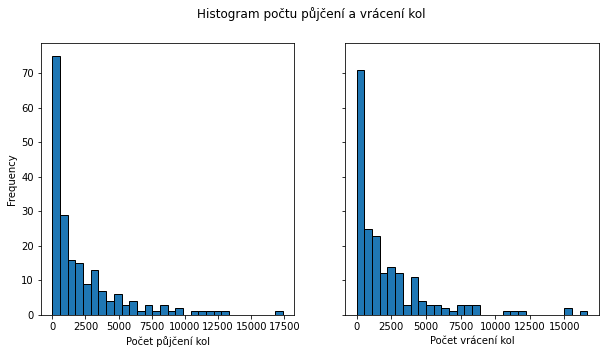

In [51]:
# histogram počtu půjčení a vrácení kol
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)  # Jeden řádek, dva sloupce, první graf
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)  # Druhý graf, sdílená osa Y
dfs1.start_frequency.plot.hist(ax=ax1, bins=30, edgecolor='black');
dfs1.end_frequency.plot.hist(ax=ax2, bins=30, edgecolor='black');
fig.suptitle("Histogram počtu půjčení a vrácení kol");
ax1.set_xlabel("Počet půjčení kol");
ax2.set_xlabel("Počet vrácení kol");


Z histogramu vidíme, že se nejedná o normální rozdělení pravděpodobnosti, ale šikmé rozdělení, takže v datech se vyskytují odlehlé hodnoty.   
Tyto hodnoty představují málo využívané stanice, u kterých by bylo potřeba vyhodnotit jestli je není vhodné zrušit.

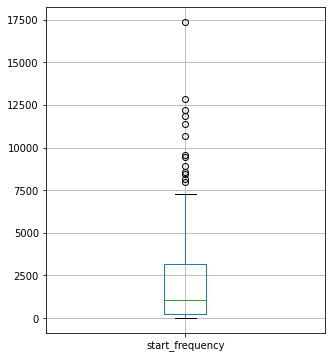

In [52]:
#  inter-quartile range
dfs1.boxplot(column="start_frequency", figsize=(5, 6));

Z boxplotu lze vidět, že hodnoty přibližně nad 7500 jsou odlehlé -> výpočet níže.

In [53]:
# Metoda IQR - interquartal range 
Q1_s = dfs1.start_frequency.quantile(0.25)
Q3_s = dfs1.start_frequency.quantile(0.75)
IQR_s = Q3_s - Q1_s

Q1_e = dfs1.end_frequency.quantile(0.25)
Q3_e = dfs1.end_frequency.quantile(0.75)
IQR_e = Q3_e - Q1_e

# zobrazení
print("Q1 pro vypůjčení: ", Q1_s)
print("Q3 pro vypůjčení: ", Q3_s)
print("IQR pro vypůjčení: ", IQR_s)
print('')
print("Q1 pro vrácení: ", Q1_e)
print("Q3 pro vrácení: ", Q3_e)
print("IQR pro vrácení: ", IQR_e)

Q1 pro vypůjčení:  257.0
Q3 pro vypůjčení:  3154.5
IQR pro vypůjčení:  2897.5

Q1 pro vrácení:  236.0
Q3 pro vrácení:  2892.0
IQR pro vrácení:  2656.0


In [54]:
# bounders
weak_outlier_s = Q3_s + 1.5 * IQR_s
strong_outlier_s = Q3_s + 3 * IQR_s

weak_outlier_e = Q3_e + 1.5 * IQR_e
strong_outlier_e = Q3_e + 3 * IQR_e

# df outlier
df_s_weak = dfs1["start_frequency"][dfs1["start_frequency"] > weak_outlier_s].count()
df_s_strong = dfs1["start_frequency"][dfs1["start_frequency"] > strong_outlier_s].count()

df_e_weak = dfs1["end_frequency"][dfs1["end_frequency"] > weak_outlier_e].count()
df_e_strong = dfs1["end_frequency"][dfs1["end_frequency"] > strong_outlier_e].count()

# zobrazení
print(f"Hranice slabé odlehlé hodnoty vypůjčení kol je: {weak_outlier_s} a počet stanic: {df_s_weak}")
print(f"Hranice silné odlehlé hodnoty vypůjčení kol je: {strong_outlier_s} a počet stanic: {df_s_strong}")
print("")
print(f"Hranice slabé odlehlé hodnoty vrácení kol je: {weak_outlier_e} a počet stanic: {df_e_weak}")
print(f"Hranice silné odlehlé hodnoty vrácení kol je: {strong_outlier_e} a počet stanic: {df_e_strong}")

Hranice slabé odlehlé hodnoty vypůjčení kol je: 7500.75 a počet stanic: 13
Hranice silné odlehlé hodnoty vypůjčení kol je: 11847.0 a počet stanic: 3

Hranice slabé odlehlé hodnoty vrácení kol je: 6876.0 a počet stanic: 16
Hranice silné odlehlé hodnoty vrácení kol je: 10860.0 a počet stanic: 6


Další metoda určení odlehlých hodnot může být Z score.

**Z score**   
je metoda detekce odlehlých měření definovaná jednoduchým vzorcem a závislá na směrodatné odchylce. Právě díky jednoduchému vzorečku a nastavitelné hranici je možné si určit, co pro nás znamená odlehlé měření.   
Vzorec vypadá následovně: $$ z = \frac{x - \mu}{\sigma} $$

In [55]:
# filtrace dat pro hodnoty vetsi jak smerodatna odchylka
std = 3
zs = abs((dfs1.start_frequency - dfs1.start_frequency.mean()) / dfs1.start_frequency.std())
dfs1.start_frequency[zs > std]

1      12218.0
9      17390.0
16     12846.0
98     11373.0
137    11843.0
Name: start_frequency, dtype: float64

#### Mapa stanic<a name="3.1.1"></a>

In [56]:
# vykreslení mapy stanic
fig = px.scatter_mapbox(dfs1,lat="lat", lon="lon", hover_name = "name",
                        hover_data = ["description","start_frequency",
                                      "end_frequency"] ,zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Vzdálenosti stanic<a name="3.1.2"></a>

In [57]:
# kopie dataframu pro výpočet vzdáleností seřazená podle id
df_s2 = dfs1.copy().sort_values(by="id")

postup výpočtu vzdáleností:   
https://medium.com/@danalindquist/finding-the-distance-between-two-lists-of-geographic-coordinates-9ace7e43bb2f

In [58]:
# převedení na radiány
df_s2['lat'] = np.radians(df_s2['lat'])
df_s2['lon'] = np.radians(df_s2['lon'])

In [59]:
# vytvoření matice pomocí knihovny
dist = DistanceMetric.get_metric('haversine')

In [60]:
# radius země v km
earth_radius = 6373
# matice s výpočtem vzdálenosti mezi stanicemi v km
distance = pd.DataFrame(dist.pairwise(
    (df_s2[['lat','lon']]) * earth_radius).round(2),
      columns=df_s2.id, index=df_s2.id)

In [61]:
distance.head()

id,171,183,189,225,241,242,246,247,248,249,...,1868,1869,1870,1871,1874,1877,2259,2263,2265,2268
id,,,,,,,,,,,,,,,,,,,,,
171,0.00,0.96,0.80,1.03,1.84,1.84,0.64,1.92,0.33,1.15,...,1.07,0.89,0.23,1.09,1.30,0.70,2.47,0.58,1.05,1.51
183,0.96,0.00,0.19,0.81,1.13,1.13,1.59,1.75,0.66,1.78,...,1.58,1.60,1.18,0.57,1.36,1.59,1.51,1.37,1.95,0.80
189,0.80,0.19,0.00,0.70,1.18,1.18,1.44,1.88,0.48,1.74,...,1.56,1.53,1.02,0.69,1.43,1.46,1.67,1.18,1.76,0.83
225,1.03,0.81,0.70,0.00,0.83,0.83,1.51,2.54,0.79,2.18,...,2.09,1.92,1.22,1.37,2.11,1.69,1.65,0.97,1.47,0.58
241,1.84,1.13,1.18,0.83,0.00,0.00,2.33,2.10,1.54,2.91,...,2.69,2.70,2.04,1.54,2.28,2.52,0.85,1.76,2.08,0.35


#### Aktivní a neaktivní stanice<a name="3.1.2"></a>


Z posbíraných dat jsme zjistili, že se průměrně půčují 2,2 kola denně na každé stanici. Pro určení aktivních stanic jsme si určili, že za aktivní stanice budeme považovat pouze stanice, na kterých proběhne v průměru minimálně **0,3** výpujček kol denně.

In [62]:
# pocet vypujceni prepoctenych na 0,3 denně
rent_by_day = 0.3
days_variable = rent_by_day * date_range
# vsechny stanice, které mají v průměru méně jak 0,3 výpujček kol za den
active_stations = dfs1[dfs1["start_frequency"] > days_variable]
inactive_stations = dfs1[dfs1["start_frequency"] < days_variable]


In [63]:
print(f"Počet aktivních stanic je: {active_stations.id.count()} stanic")
print(f"Počet neaktivních stanic je: {inactive_stations.id.count()} stanic")

Počet aktivních stanic je: 145 stanic
Počet neaktivních stanic je: 53 stanic


#### Nejfrekventovanější stanice<a name="3.1.2"></a>

In [64]:
# 10 nejfrekventovanějších stanic pro vypůjčení kola
top_rent_stations = active_stations.sort_values(
    by= "start_frequency", ascending= False).head(10).reset_index()

In [65]:
top_rent_stations

,index,id,name,description,lat,lon,distance,start_frequency,end_frequency
0,9,265,Meadows East,Melville Terrace,55.939809,-3.182739,0.781461,17390.0,15225.0
1,16,248,Bristo Square,"Bristo Square, near Potter Row",55.946004,-3.188665,1.005436,12846.0,7898.0
2,1,259,St Andrew Square,North East corner,55.954749,-3.192774,0.921967,12218.0,8372.0
3,137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,4.417536,11843.0,16656.0
4,98,1024,Meadow Place 2,,55.940238,-3.194640,1.343822,11373.0,8792.0
5,17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,0.000000,10662.0,15254.0
6,2,262,Canonmills,near Tesco's,55.962804,-3.196284,2.150241,9551.0,11940.0
7,7,264,Pollock Halls,Pollock Halls Entrance,55.939963,-3.171586,0.000000,9441.0,6628.0
8,31,289,Castle Street,Near Rose Street,55.951501,-3.203184,1.328247,8923.0,7398.0
9,10,183,Waverley Bridge,near the top of the South ramp,55.951344,-3.191421,1.311092,8569.0,8402.0


In [66]:
# 10 nejfrekventovanějších stanic pro vypůjčení kola
top_return_stations = active_stations.sort_values(
    by= "end_frequency", ascending= False).head(10).reset_index()

In [67]:
top_return_stations

,index,id,name,description,lat,lon,distance,start_frequency,end_frequency
0,137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,4.417536,11843.0,16656.0
1,17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,0.000000,10662.0,15254.0
2,9,265,Meadows East,Melville Terrace,55.939809,-3.182739,0.781461,17390.0,15225.0
3,2,262,Canonmills,near Tesco's,55.962804,-3.196284,2.150241,9551.0,11940.0
4,180,1824,Duke Street,Junction with Easter Road,55.969012,-3.167395,2.785309,7288.0,11264.0
5,44,358,Leith Walk,Leith Walk opposite Dalmeny Street,55.965040,-3.176686,1.777731,7964.0,11052.0
6,98,1024,Meadow Place 2,,55.940238,-3.194640,1.343822,11373.0,8792.0
7,10,183,Waverley Bridge,near the top of the South ramp,55.951344,-3.191421,1.311092,8569.0,8402.0
8,1,259,St Andrew Square,North East corner,55.954749,-3.192774,0.921967,12218.0,8372.0
9,22,258,Stockbridge,Hamilton Place by Dean Bank Lane,55.958566,-3.208070,1.042496,6219.0,8212.0


#### Dostupnost kol na stanicích<a name="3.1.2"></a>

Pro výpočet hromadění a nedostatku kol na stanicích si definujeme, že nás zajímají pouze stanice, kterým chybí nebo je přebytek kol průměrně větší jak **3 kola na den.**

In [68]:
# proměnná počet kol za den
rent_diff = 3

In [69]:
df_s_new = dfs1.copy()

In [70]:
# výpočet rozdílu mezi počtem vypůjčení a vrácení kol přepočítaných na den
df_s_new["bikes_on_stations"] = (
    df_s_new["start_frequency"] - df_s_new["end_frequency"]) / date_range

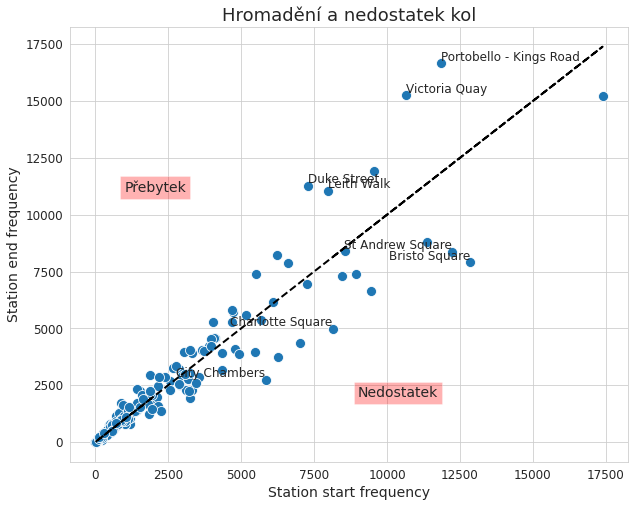

In [100]:
# graf nadbytku kol
plt.rcParams['font.size'] = '12'
fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('whitegrid')
sns.scatterplot(data=df_s_new, x='start_frequency', y='end_frequency', ax=ax, s=100)
plt.title('Hromadění a nedostatek kol', fontsize=18)
plt.xlabel('Station start frequency', fontsize=14)
plt.ylabel('Station end frequency', fontsize=14)
# vykreslení identity line:
x = df_s_new['start_frequency']
plt.plot(x, x, color='k', linestyle='--', linewidth=2)

# Anotace bodů s největším rozdílem:
masks = [(df_s_new['bikes_on_stations'] > rent_diff), (df_s_new['bikes_on_stations'] < - rent_diff)]
for i in range(2):
  x = df_s_new['start_frequency'][masks[i]]
  y = df_s_new['end_frequency'][masks[i]]
  names = df_s_new['name'][masks[i]]
  if i == 0:
    texts = [plt.text(x1, y1, name, ha='right', va='bottom') for x1, y1, name in zip(x, y, names)]
  elif i == 1:
    texts = [plt.text(x1, y1, name, ha='left', va='bottom') for x1, y1, name in zip(x, y, names)]
plt.text(1000, 11000, 'Přebytek', fontsize=14, bbox=dict(facecolor='red', alpha=0.3))
plt.text(9000, 2000, 'Nedostatek', fontsize=14, bbox=dict(facecolor='red', alpha=0.3 ))
plt.show()

In [72]:
# nedostatek kol
not_enough = df_s_new[df_s_new["bikes_on_stations"] >= rent_diff].sort_values(by="bikes_on_stations")

In [73]:
# hromadění kol
too_much = df_s_new[df_s_new["bikes_on_stations"] <= (- rent_diff)].sort_values(by="bikes_on_stations")

In [74]:
too_much

,id,name,description,lat,lon,distance,start_frequency,end_frequency,bikes_on_stations
137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,4.417536,11843.0,16656.0,-4.723258
17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,0.000000,10662.0,15254.0,-4.506379
180,1824,Duke Street,Junction with Easter Road,55.969012,-3.167395,2.785309,7288.0,11264.0,-3.901865
44,358,Leith Walk,Leith Walk opposite Dalmeny Street,55.965040,-3.176686,1.777731,7964.0,11052.0,-3.030422


In [75]:
not_enough

,id,name,description,lat,lon,distance,start_frequency,end_frequency,bikes_on_stations
11,189,City Chambers,City Chambers Quadrangle,55.950109,-3.190258,0.000000,5836.0,2723.0,3.054956
0,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,0.937974,8134.0,4980.0,3.095191
1,259,St Andrew Square,North East corner,55.954749,-3.192774,0.921967,12218.0,8372.0,3.774289
16,248,Bristo Square,"Bristo Square, near Potter Row",55.946004,-3.188665,1.005436,12846.0,7898.0,4.855741


*   Na **4 stanicích** je průměrně nedostatek kol.
*   Na **4 stanicích** je průměrně přebytek kol.

Pro stanice s přebytkem kol je potřeba zajistit přepravu do nejbližší stanice, která má nedostatek kol a naopak.

### Záznamy o zapůjčení<a name="3.1.2"></a>

#### Doba výpujčky<a name="3.1.2"></a>

In [76]:
dfb1["duration"].describe()

count                       438259
mean     0 days 00:32:28.838038694
std      0 days 01:34:17.134780300
min                0 days 00:01:01
25%                0 days 00:10:24
50%                0 days 00:19:23
75%                0 days 00:42:09
max               27 days 08:29:08
Name: duration, dtype: object

In [77]:
# převedení na datový formát float
dfb1["duration_sec"] = dfb1.duration.astype('timedelta64[s]')

In [78]:
dfb1["duration_sec"] = dfb1["duration_sec"]

In [79]:
dfb1["duration_sec"].describe().round(2)

count     438259.00
mean        1948.84
std         5657.13
min           61.00
25%          624.00
50%         1163.00
75%         2529.00
max      2363348.00
Name: duration_sec, dtype: float64

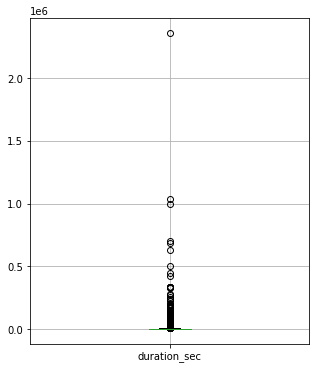

In [80]:
#  inter-quartile range
dfb1.boxplot(column="duration_sec", figsize=(5, 6));

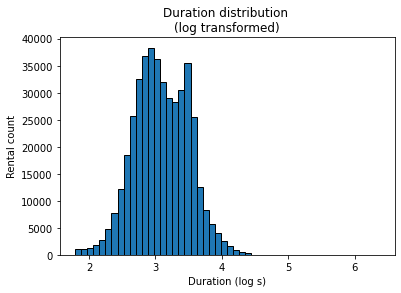

In [81]:
# histogram délky výpujčky kola
plt.hist(x = np.log10(dfb1['duration_sec']), bins=50, edgecolor='black');
plt.title('Duration distribution \n(log transformed)')
plt.xlabel('Duration (log s)')
plt.ylabel('Rental count')
plt.show()

Histogram je zkreslený odlehlými hodnoty, které odstraníme pomocí metody z-score ± 3 směrodatné ochylky

In [82]:
# Odstranění odlehlých hodnot
df_b_outlier = dfb1[(np.abs(stats.zscore(dfb1['duration_sec'])) < 3)]

In [83]:
df_b_outlier.duration.describe()

count                       437296
mean     0 days 00:30:55.535854432
std      0 days 00:33:05.583055047
min                0 days 00:01:01
25%                0 days 00:10:23
50%                0 days 00:19:20
75%                0 days 00:41:56
max                0 days 05:15:17
Name: duration, dtype: object

Bez odlehlých hodnot lze vidět, že:
*   průměrná doba výpujčky je **30min**
*   směrodatná odchylka je **33 min**
*   nejkratší výpujčka je **1 min**
*   nejdelší výpujčka **5 hod 15 min**

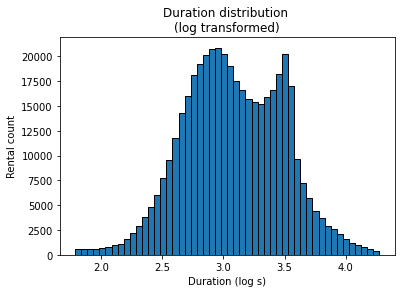

In [84]:
# histogram délky výpujčky kola po odstranění odlehlých hodnot
freqs, bins, bars = plt.hist(x = np.log10(df_b_outlier['duration_sec']), bins=50, edgecolor='black');
plt.title('Duration distribution \n(log transformed)')
plt.xlabel('Duration (log s)')
plt.ylabel('Rental count')
plt.show()

Z histogramu lze vidět, že se nachází dva peaky délky výpujček kol.   
* První peak je **krátkodobější výpujčka** a zjistíme ho z levé poloviny histogramu.   
* Druhý je **dlouhodobější výpujčka** a zjistíme ho z pravé poloviny histogramu.

#### Poptávka